**Import libraries**

In [41]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

**Transformations**

In [42]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                       transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.RandomHorizontalFlip(p=0.3),
                                       transforms.RandomRotation((-7.0, 7.0), fill=(1,1,1)),
                                       transforms.ToTensor(),
                                       transforms.Normalize( (0.49139968, 0.48215827 ,0.44653124), (0.24703233, 0.24348505, 0.26158768) ), # The mean and std
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.49139968, 0.48215827 ,0.44653124), (0.24703233, 0.24348505, 0.26158768)), # The mean and std
                                       ])



**Creating test / train split and downloading data**



In [43]:

train = datasets.CIFAR10('./data', train=True, download=True, transform=train_transforms)
test = datasets.CIFAR10('./data', train=False, download=True, transform=test_transforms)

Files already downloaded and verified
Files already downloaded and verified


**Data loader arguments and test train data loaders**

In [44]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=2, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


**Model**

In [53]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self, norm='BN',groupsize=2,drop=0.05):
        super(Net, self).__init__()

        # CONVOLUTION BLOCK 1
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),
            self.net_norm(norm,32,groupsize),
            nn.Dropout(drop),
            nn.Conv2d(in_channels=32, out_channels=54, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),
            self.net_norm(norm,54,groupsize),
            nn.Dropout(drop),
            nn.Conv2d(in_channels=54, out_channels=10, kernel_size=(1, 1), padding=0, bias=False)
        )

        # CONVOLUTION BLOCK 2
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=16, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),
            self.net_norm(norm,16,groupsize),
            nn.Dropout(drop),
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),
            self.net_norm(norm,16,groupsize),
            nn.Dropout(drop),
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),
            self.net_norm(norm,32,groupsize),
            nn.Dropout(drop),
            nn.Conv2d(in_channels=32, out_channels=16, kernel_size=(1, 1), padding=0, bias=False)
        )

        self.pool1 = nn.MaxPool2d(2, 2)

        # CONVOLUTION BLOCK 3
        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),
            self.net_norm(norm,32,groupsize),
            nn.Dropout(drop),
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),
            self.net_norm(norm,32,groupsize),
            nn.Dropout(drop),
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),
            self.net_norm(norm,32,groupsize),
            nn.Dropout(drop),
        )

        self.pool2 = nn.AvgPool2d(kernel_size=8)

        # CONVOLUTION BLOCK 4
        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=10, kernel_size=(1, 1), padding=0, bias=False)
        )

    def forward(self, x):
        x = self.pool1(self.convblock1(x))
        x = self.pool1(self.convblock2(x))
        x = self.pool2(self.convblock3(x))
        x = self.convblock4(x)
        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

    def net_norm(self, norm, channels,groupsize=2):
        if norm == 'BN':
            return nn.BatchNorm2d(channels)
        elif norm == 'LN':
            return nn.GroupNorm(1,channels) #(equivalent with LayerNorm)
        elif norm == 'GN':
            return nn.GroupNorm(groupsize,channels) #groups=2

In [54]:
from tqdm import tqdm
import numpy as np

def train(model, device, train_loader, optimizer, epoch, train_losses, train_acc):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm

    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader, test_losses, test_acc):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

    test_acc.append(100. * correct / len(test_loader.dataset))

def print_graph(train_losses,train_acc, test_losses,test_acc):
    fig, axs = plt.subplots(2,2,figsize=(15,10))
    axs[0, 0].plot(train_losses)
    axs[0, 0].set_title("Training Loss")
    axs[1, 0].plot(train_acc)
    axs[1, 0].set_title("Training Accuracy")
    axs[0, 1].plot(test_losses)
    axs[0, 1].set_title("Test Loss")
    axs[1, 1].plot(test_acc)
    axs[1, 1].set_title("Test Accuracy")

def show_images(loader):
    classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

    dataiter = iter(loader)
    images, labels = next(dataiter)

    num_of_images = 10
    fig = plt.figure(figsize=(10,5))

    for index in range(1, num_of_images+1):
        ax = fig.add_subplot(2, 5, index)
        ax.axis('off')
        actual = classes[labels[index]]
        ax.set_title(f'\n Label : {actual}',fontsize=10)
        ax.imshow(np.transpose(images[index], (1, 2, 0)))

def display_incorrect_images(mismatch, n=20 ):
    classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
    display_images = mismatch[:n]
    index = 0
    fig = plt.figure(figsize=(10,5))
    for img in display_images:
        image = img[0].squeeze().to('cpu').numpy()
        pred = classes[img[1]]
        actual = classes[img[2]]
        ax = fig.add_subplot(2, 5, index+1)
        ax.axis('off')
        ax.set_title(f'\n Predicted Label : {pred} \n Actual Label : {actual}',fontsize=10)
        ax.imshow(np.transpose(image, (1, 2, 0)))
        index = index + 1
    plt.show()

**Model Summary**

In [55]:

#!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(3, 32, 32))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             864
              ReLU-2           [-1, 32, 32, 32]               0
       BatchNorm2d-3           [-1, 32, 32, 32]              64
           Dropout-4           [-1, 32, 32, 32]               0
            Conv2d-5           [-1, 54, 32, 32]          15,552
              ReLU-6           [-1, 54, 32, 32]               0
       BatchNorm2d-7           [-1, 54, 32, 32]             108
           Dropout-8           [-1, 54, 32, 32]               0
            Conv2d-9           [-1, 10, 32, 32]             540
        MaxPool2d-10           [-1, 10, 16, 16]               0
           Conv2d-11           [-1, 16, 16, 16]           1,440
             ReLU-12           [-1, 16, 16, 16]               0
      BatchNorm2d-13           [-1, 16, 16, 16]              32
          Dropout-14           [-1

In [56]:

from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

In [57]:

from torch.optim.lr_scheduler import StepLR

model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
#scheduler = StepLR(optimizer, step_size=6, gamma=0.1)
EPOCHS = 20
for epoch in range(EPOCHS):
    print("EPOCH:", epoch + 1 )
    train(model, device, train_loader, optimizer, epoch,train_losses, train_acc)
    #scheduler.step()
    test(model, device, test_loader,test_losses, test_acc)

EPOCH: 1


Loss=1.2130051851272583 Batch_id=390 Accuracy=42.10: 100%|██████████| 391/391 [00:50<00:00,  7.71it/s]



Test set: Average loss: 1.3519, Accuracy: 4991/10000 (49.91%)

EPOCH: 2


Loss=1.1694247722625732 Batch_id=390 Accuracy=56.18: 100%|██████████| 391/391 [00:50<00:00,  7.76it/s]



Test set: Average loss: 1.0738, Accuracy: 6136/10000 (61.36%)

EPOCH: 3


Loss=1.0002555847167969 Batch_id=390 Accuracy=61.15: 100%|██████████| 391/391 [00:51<00:00,  7.65it/s]



Test set: Average loss: 1.0312, Accuracy: 6283/10000 (62.83%)

EPOCH: 4


Loss=0.8193256258964539 Batch_id=390 Accuracy=64.45: 100%|██████████| 391/391 [00:50<00:00,  7.79it/s]



Test set: Average loss: 0.9522, Accuracy: 6635/10000 (66.35%)

EPOCH: 5


Loss=0.8553738594055176 Batch_id=390 Accuracy=66.84: 100%|██████████| 391/391 [00:50<00:00,  7.74it/s]



Test set: Average loss: 0.8888, Accuracy: 6865/10000 (68.65%)

EPOCH: 6


Loss=1.0082334280014038 Batch_id=390 Accuracy=68.64: 100%|██████████| 391/391 [00:51<00:00,  7.58it/s]



Test set: Average loss: 0.8434, Accuracy: 7008/10000 (70.08%)

EPOCH: 7


Loss=0.8273279070854187 Batch_id=390 Accuracy=70.28: 100%|██████████| 391/391 [00:52<00:00,  7.47it/s]



Test set: Average loss: 0.7785, Accuracy: 7229/10000 (72.29%)

EPOCH: 8


Loss=0.8912484049797058 Batch_id=390 Accuracy=71.63: 100%|██████████| 391/391 [00:50<00:00,  7.79it/s]



Test set: Average loss: 0.7611, Accuracy: 7329/10000 (73.29%)

EPOCH: 9


Loss=0.7278522253036499 Batch_id=390 Accuracy=72.60: 100%|██████████| 391/391 [00:50<00:00,  7.77it/s]



Test set: Average loss: 0.7282, Accuracy: 7491/10000 (74.91%)

EPOCH: 10


Loss=0.8168178796768188 Batch_id=390 Accuracy=73.61: 100%|██████████| 391/391 [00:49<00:00,  7.94it/s]



Test set: Average loss: 0.7239, Accuracy: 7458/10000 (74.58%)

EPOCH: 11


Loss=0.6454334259033203 Batch_id=390 Accuracy=74.49: 100%|██████████| 391/391 [00:49<00:00,  7.92it/s]



Test set: Average loss: 0.6958, Accuracy: 7605/10000 (76.05%)

EPOCH: 12


Loss=0.9280506372451782 Batch_id=390 Accuracy=74.86: 100%|██████████| 391/391 [00:49<00:00,  7.84it/s]



Test set: Average loss: 0.6753, Accuracy: 7625/10000 (76.25%)

EPOCH: 13


Loss=1.0383821725845337 Batch_id=390 Accuracy=75.31: 100%|██████████| 391/391 [00:49<00:00,  7.90it/s]



Test set: Average loss: 0.6435, Accuracy: 7710/10000 (77.10%)

EPOCH: 14


Loss=0.8395527005195618 Batch_id=390 Accuracy=75.85: 100%|██████████| 391/391 [00:50<00:00,  7.74it/s]



Test set: Average loss: 0.6499, Accuracy: 7694/10000 (76.94%)

EPOCH: 15


Loss=0.7523175477981567 Batch_id=390 Accuracy=76.49: 100%|██████████| 391/391 [00:48<00:00,  7.99it/s]



Test set: Average loss: 0.6243, Accuracy: 7831/10000 (78.31%)

EPOCH: 16


Loss=0.6732841730117798 Batch_id=390 Accuracy=76.81: 100%|██████████| 391/391 [00:49<00:00,  7.97it/s]



Test set: Average loss: 0.6225, Accuracy: 7851/10000 (78.51%)

EPOCH: 17


Loss=0.6437853574752808 Batch_id=390 Accuracy=76.94: 100%|██████████| 391/391 [00:49<00:00,  7.95it/s]



Test set: Average loss: 0.6072, Accuracy: 7893/10000 (78.93%)

EPOCH: 18


Loss=0.5362383723258972 Batch_id=390 Accuracy=77.66: 100%|██████████| 391/391 [00:51<00:00,  7.60it/s]



Test set: Average loss: 0.6354, Accuracy: 7813/10000 (78.13%)

EPOCH: 19


Loss=0.6662870645523071 Batch_id=390 Accuracy=77.88: 100%|██████████| 391/391 [00:49<00:00,  7.90it/s]



Test set: Average loss: 0.5959, Accuracy: 7910/10000 (79.10%)

EPOCH: 20


Loss=0.5245105028152466 Batch_id=390 Accuracy=78.33: 100%|██████████| 391/391 [00:51<00:00,  7.64it/s]



Test set: Average loss: 0.5904, Accuracy: 7926/10000 (79.26%)



In [58]:

train_losses1 = [t.cpu().item() for t in train_losses]

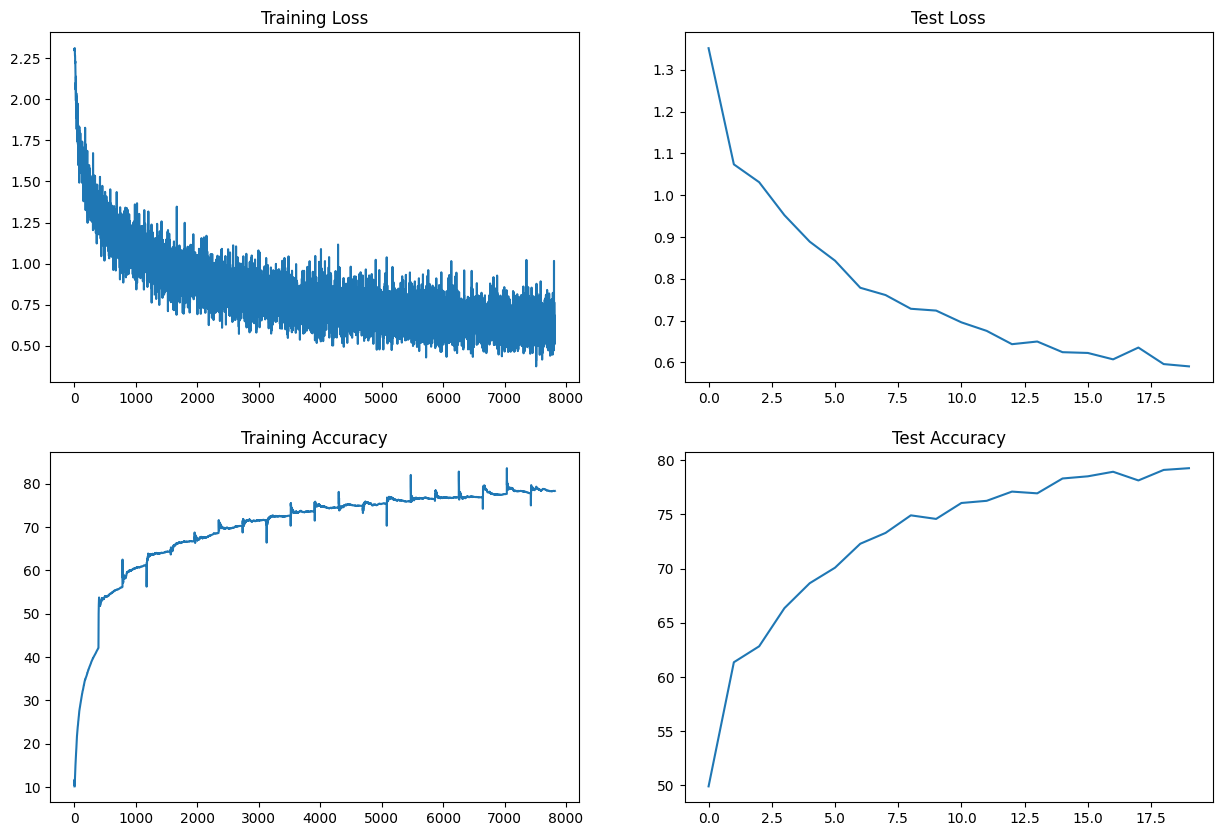

In [59]:

print_graph(train_losses1,train_acc, test_losses,test_acc)

In [60]:
wrong_prediction_list = []
model.eval()
for images, labels in test_loader:
    images, labels = images.to(device), labels.to(device)
    output = model(images)
    pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    match = pred.eq(labels.view_as(pred)).to('cpu').numpy()
    for j, i in enumerate(match):
        if(i == False):
            wrong_prediction_list.append((images[j], pred[j].item(), labels[j].item()))

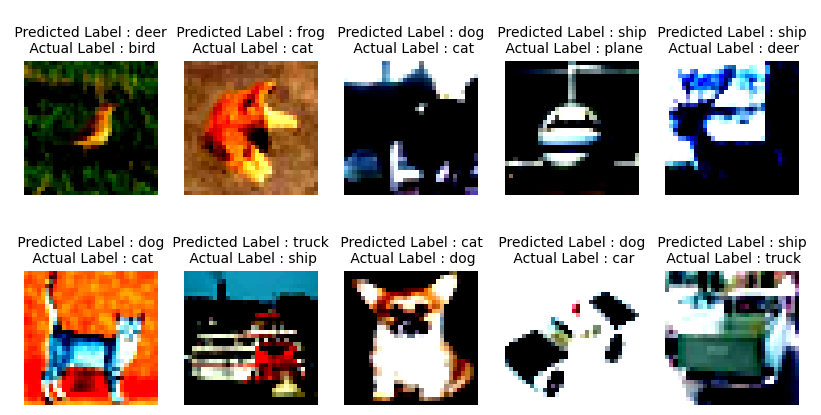

In [61]:

display_incorrect_images(wrong_prediction_list, n=10 )